In [1]:
  #!pip install torchinfo

import pandas as pd
import numpy as np
import torch
import os
import shutil
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
import seaborn as sns
from torchvision.models import ResNet50_Weights
from sklearn.metrics import classification_report, confusion_matrix
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms.functional import to_pil_image
from torchvision import transforms
from torchinfo import summary
from PIL import Image


In [2]:
# Source directory
import shutil

source_dir = "/kaggle/input/skin-cancer-mnist-ham10000"

# Destination directory
destination_dir = "/kaggle/working/Dataset"

shutil.copytree(source_dir, destination_dir)

'/kaggle/working/Dataset'

In [3]:
# Define a function to combine images in different folders into 1 folders
def combine_folders(src1, src2, dest):

    copied_files = []  # List to store names of successfully copied files

    # Create folder when destination folder not exist, exit function if destination folder contains contents from the source folder
    if not os.path.exists(dest):
      print(f"Destination folder {dest} created...")
      os.makedirs(dest)

    else:
      # Recreate folder when destination folder do not have all the contents in source folders to avoid overlapping contents
      if len(os.listdir(dest)) == (len(os.listdir(src1)) + len(os.listdir(src2))):
        print("Content in source 1 folder and source 2 folder have been copied to destination folder")

        for filename in os.listdir(dest):
            copied_files.append(filename)

        return copied_files

      else:
        shutil.rmtree(dest)
        os.makedirs(dest)


    print(f"Copying images in {src1} into {dest}...")

    # Loop through all content in source folder 1 and copy into destination folder, if source 1 folder exist
    if os.path.exists(src1):
      print('Source 1 folder consist of ', len(os.listdir(src1)), " elements")

      for images in os.listdir(src1):

        # Define the source path and the destination path for each images
        src_path = os.path.join(src1, images)
        dest_path = os.path.join(dest, images)

        # Copy to the destination folder
        shutil.copy(src_path, dest_path)
        copied_files.append(images)

      print(f"All images in {src1} have been copied into {dest}...")

    else:
      print(f"{src1} not found")


    print(f"Copying images in {src2} into {dest}...")

    # loop through all content in source folder 2 and copy into destination folder, if source 2 folder exist
    if os.path.exists(src2):
      print('Source 2 folder consist of ', len(os.listdir(src2)), " elements")

      for images in os.listdir(src2):

        # Define the source path and the destination path for each images
        src_path = os.path.join(src2, images)
        dest_path = os.path.join(dest, images)

        # Copy to the destination folder
        shutil.copy(src_path, dest_path)
        copied_files.append(images)

      print(f"All images in {src2} have been copied into {dest}...")

    else:
      print(f"{src2} not found")

    print('Destination folder consist of ', len(os.listdir(dest)), " elements")

    return copied_files

In [4]:
# Define source paths to combined and destination path to store
src1 = "/kaggle/working/Dataset/HAM10000_images_part_1/"
src2 = "/kaggle/working/Dataset/HAM10000_images_part_2/"
dest = "/kaggle/working/Dataset/HAM10000/"
copied_files = combine_folders(src1, src2, dest)

Destination folder /kaggle/working/Dataset/HAM10000/ created...
Copying images in /kaggle/working/Dataset/HAM10000_images_part_1/ into /kaggle/working/Dataset/HAM10000/...
Source 1 folder consist of  5000  elements
All images in /kaggle/working/Dataset/HAM10000_images_part_1/ have been copied into /kaggle/working/Dataset/HAM10000/...
Copying images in /kaggle/working/Dataset/HAM10000_images_part_2/ into /kaggle/working/Dataset/HAM10000/...
Source 2 folder consist of  5015  elements
All images in /kaggle/working/Dataset/HAM10000_images_part_2/ have been copied into /kaggle/working/Dataset/HAM10000/...
Destination folder consist of  10015  elements


In [5]:
train_file = "Dataset/HAM10000_metadata.csv"
skin_df = pd.read_csv(train_file)
skin_df.shape

(10015, 7)

In [6]:
# Get unique values of lesion_id
unique_lesion_ids = skin_df['lesion_id'].unique()
print(unique_lesion_ids)

# Create a new DataFrame with unique lesion_id values and all other columns
unique_lesion_df = pd.DataFrame({'lesion_id': unique_lesion_ids})
print(unique_lesion_df)

# Merge the unique_lesion_df with the original skin_df on lesion_id
skin_df = pd.merge(unique_lesion_df, skin_df.drop_duplicates(subset=['lesion_id']), on='lesion_id')
skin_df.shape

['HAM_0000118' 'HAM_0002730' 'HAM_0001466' ... 'HAM_0005579' 'HAM_0001576'
 'HAM_0002867']
        lesion_id
0     HAM_0000118
1     HAM_0002730
2     HAM_0001466
3     HAM_0002761
4     HAM_0005132
...           ...
7465  HAM_0000193
7466  HAM_0000020
7467  HAM_0005579
7468  HAM_0001576
7469  HAM_0002867

[7470 rows x 1 columns]


(7470, 7)

In [7]:
from sklearn.model_selection import train_test_split
raw_train_df, valid_df = train_test_split(skin_df,
                 test_size = 0.3)
print(raw_train_df.shape[0], 'training masks')
print(valid_df.shape[0], 'validation masks')

5229 training masks
2241 validation masks


# Group-wise Sampling for Class Balancing in Training Data

In [8]:
SAMPLE_PER_GROUP = 1500
train_df = raw_train_df.groupby('dx', as_index=False).apply(lambda x: x.sample(SAMPLE_PER_GROUP//2, replace=True)).reset_index(drop=True)
print(train_df.shape[0])
print(train_df['dx'].value_counts())

5250
dx
akiec    750
bcc      750
bkl      750
df       750
mel      750
nv       750
vasc     750
Name: count, dtype: int64


/tmp/ipykernel_34/1395859830.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_df = raw_train_df.groupby('dx', as_index=False).apply(lambda x: x.sample(SAMPLE_PER_GROUP//2, replace=True)).reset_index(drop=True)


In [9]:
train_df.head(5)

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0005579,ISIC_0029309,akiec,histo,80.0,male,face
1,HAM_0000718,ISIC_0025130,akiec,histo,80.0,female,face
2,HAM_0005438,ISIC_0027708,akiec,histo,50.0,female,face
3,HAM_0001173,ISIC_0030827,akiec,histo,40.0,female,face
4,HAM_0005255,ISIC_0025811,akiec,histo,55.0,male,upper extremity


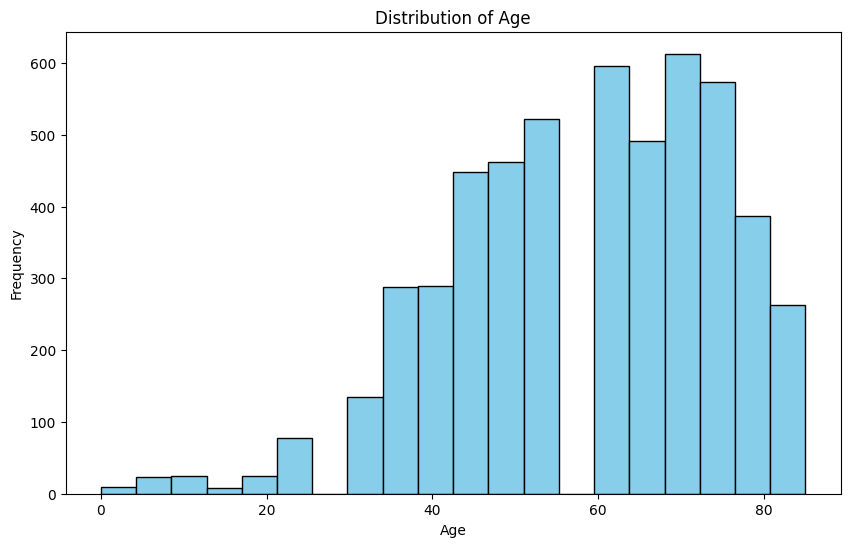

In [10]:
plt.figure(figsize=(10, 6))
plt.hist(train_df['age'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Distribution of Age')
plt.show()

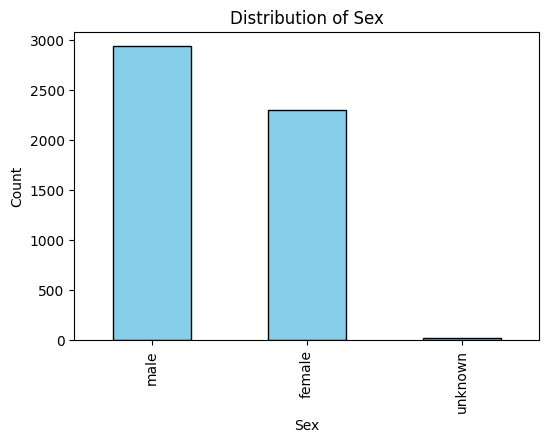

In [11]:
plt.figure(figsize=(6, 4))
train_df['sex'].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.title('Distribution of Sex')
plt.show()

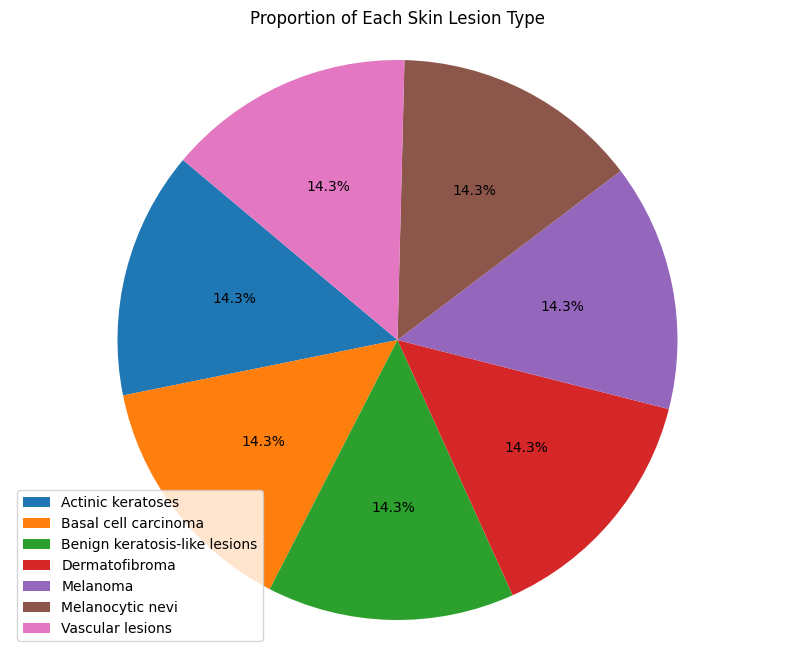

In [12]:
# Dictionary to map lesion type codes to their full names
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

# Get the counts of each lesion type
lesion_type_counts = train_df['dx'].value_counts()

# Create labels and sizes for the pie chart
labels = [lesion_type_dict[code] for code in lesion_type_counts.index]
sizes = lesion_type_counts.values

# Create the pie chart with percentage labels
plt.figure(figsize=(10, 8))
plt.pie(sizes, labels=None, startangle=140, autopct='%1.1f%%')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.title('Proportion of Each Skin Lesion Type')

# Add a legend based on color
plt.legend(labels, loc="best")
plt.show()

In [13]:
 # Drop columns except for image_id and dx
train_df = train_df.drop(['lesion_id', 'dx_type', 'age', 'sex', 'localization'], axis=1)
train_df.head(5)

,image_id,dx
0,ISIC_0029309,akiec
1,ISIC_0025130,akiec
2,ISIC_0027708,akiec
3,ISIC_0030827,akiec
4,ISIC_0025811,akiec


In [14]:
print('Shape of train_df : ', train_df.shape, '\n')

Shape of train_df :  (5250, 2) 



In [15]:
class HAM10000(Dataset):
    def __init__(self, df, root, train_mode=True, transform=None):
        self.data = []
        self.targets = []
        self.df = df
        self.root = root
        self.train_mode = train_mode
        self.transform = transform

        if self.transform is None:
            self.transform = transforms.Compose([
                transforms.Resize(384),
                transforms.RandomRotation(20),  # Random rotation between -20 to 20 degrees
                transforms.RandomHorizontalFlip(),  # Random horizontal flip
                transforms.RandomVerticalFlip(),  # Random vertical flip
                transforms.ToTensor(),  # Convert to PyTorch Tensor
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize
            ])

        # Load data and labels
        for idx in range(len(self.df)):
            filename = self.df['image_id'].iloc[idx]
            filepath = os.path.join(root, filename + '.jpg')
            if os.path.exists(filepath):
                self.data.append(filepath)
                target = self.label_to_int(self.df['dx'].iloc[idx])
                self.targets.append(target)
            else:
                print(f"File not found: {filepath}")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data[idx]
        image = Image.open(img_path)
        image = self.transform(image)
        label = self.targets[idx]
        return image, label

    def label_to_int(self, label):
        label_dict = {
            'nv': 0,      # Melanocytic nevi
            'mel': 1,     # Melanoma
            'bkl': 2,     # Benign keratosis-like lesions
            'bcc': 3,     # Basal cell carcinoma
            'akiec': 4,   # Actinic keratoses
            'vasc': 5,    # Vascular lesions
            'df': 6       # Dermatofibroma
        }
        return label_dict.get(label, -1)

In [16]:
print(train_df.shape)
print(valid_df.shape)

(5250, 2)
(2241, 7)


In [17]:
# Create dataset for training, validation and testing
trainset = HAM10000(train_df, "Dataset/HAM10000/")
testset = HAM10000(valid_df, "Dataset/HAM10000/")

In [18]:
# Show the elements in each dataset
print(f"Train set contains : {len(trainset)}\n")
print(f"Test set contains : {len(testset)}\n")

Train set contains : 5250

Test set contains : 2241



In [19]:
# Create DataLoaders and use the sampler to sample the data
trainloader = DataLoader(trainset, batch_size=8, shuffle=True)
testloader = DataLoader(testset, batch_size=8, shuffle=True)

In [20]:
def train(model, dataloader, device, num_epochs, lr=0.1, momentum=0.8, step_size=5, gamma=0.5, verbose=True):

    history = []
    loss_iterations = int(np.ceil(len(dataloader)/3))

    model = model.to(device)

    # set the optimizer
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

    # set the scheduler
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

    model.train()

    for e in range(num_epochs):

        running_loss = 0.0
        running_count = 0.0

        for i, (inputs, labels) in enumerate(dataloader):

            optimizer.zero_grad()

            if torch.cuda.is_available():
                inputs = inputs.to(device)
                labels = labels.to(device)

            labels = labels.reshape(-1, 1).float()

            outs = model(inputs)
            loss = nn.CrossEntropyLoss()(outs, labels.squeeze().long())
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            running_count += 1

            if (i + 1) % loss_iterations == 0 or i == len(dataloader) - 1:
                train_loss = running_loss / running_count
                running_loss = 0.
                running_count = 0.
                if verbose:
                    print(f'[Epoch {e+1:2d}/{num_epochs:d} Iter {i+1:5d}/{len(dataloader)}]: train_loss = {train_loss:.4f}')

                history.append(train_loss)

        # Free memory after each epoch
        del inputs, labels, outs, loss  # Delete intermediate variables

        if torch.cuda.is_available():
            torch.cuda.empty_cache()  # Empty PyTorch cache on GPU

        # update scheduler
        scheduler.step()

    return history

In [21]:
def evaluate(net, dataloader, device):
    # set to evaluation mode
    net.eval()

    # running_correct
    running_corrects = 0
    all_targets = []
    all_predicted = []

    for inputs, targets in dataloader:

        # transfer to the GPU
        if torch.cuda.is_available():
            inputs = inputs.cuda()
            targets = targets.cuda()

        # perform prediction (no need to compute gradient)
        with torch.no_grad():
            outputs = net(inputs)
            _, predicted = torch.max(outputs, 1)  # Get the index of the max log-probability
            running_corrects += (targets == predicted).sum().item()

            all_targets.extend(targets.cpu().numpy())
            all_predicted.extend(predicted.cpu().numpy())

    acc = running_corrects / len(dataloader.dataset)

    print(f'Accuracy: {acc:.2f}')

    # Calculate confusion matrix
    cm = confusion_matrix(all_targets, all_predicted)

    # Display confusion matrix as a heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[str(i) for i in range(7)], yticklabels=[str(i) for i in range(7)])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

    # Compute and display classification report
    report = classification_report(all_targets, all_predicted, target_names=[str(i) for i in range(7)])
    print("Classification Report:")
    print(report)

# Model 1: Finetuning the whole model

In [22]:
# Load pretrained ResNet50 model
model1 = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
model1.fc = nn.Linear(in_features=2048, out_features=7)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 137MB/s] 


In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
history1 = train(model1, trainloader, device, num_epochs=15, lr=0.01, step_size=5, gamma=0.1)

[Epoch  1/15 Iter   219/657]: train_loss = 1.3580
[Epoch  1/15 Iter   438/657]: train_loss = 0.8727
[Epoch  1/15 Iter   657/657]: train_loss = 0.7584
[Epoch  2/15 Iter   219/657]: train_loss = 0.5667
[Epoch  2/15 Iter   438/657]: train_loss = 0.5883
[Epoch  2/15 Iter   657/657]: train_loss = 0.5022
[Epoch  3/15 Iter   219/657]: train_loss = 0.4011
[Epoch  3/15 Iter   438/657]: train_loss = 0.4409
[Epoch  3/15 Iter   657/657]: train_loss = 0.3879
[Epoch  4/15 Iter   219/657]: train_loss = 0.2928
[Epoch  4/15 Iter   438/657]: train_loss = 0.2978
[Epoch  4/15 Iter   657/657]: train_loss = 0.3164
[Epoch  5/15 Iter   219/657]: train_loss = 0.2580
[Epoch  5/15 Iter   438/657]: train_loss = 0.2171
[Epoch  5/15 Iter   657/657]: train_loss = 0.2703
[Epoch  6/15 Iter   219/657]: train_loss = 0.1648
[Epoch  6/15 Iter   438/657]: train_loss = 0.1478
[Epoch  6/15 Iter   657/657]: train_loss = 0.1330
[Epoch  7/15 Iter   219/657]: train_loss = 0.1107
[Epoch  7/15 Iter   438/657]: train_loss = 0.1123


Accuracy: 0.83


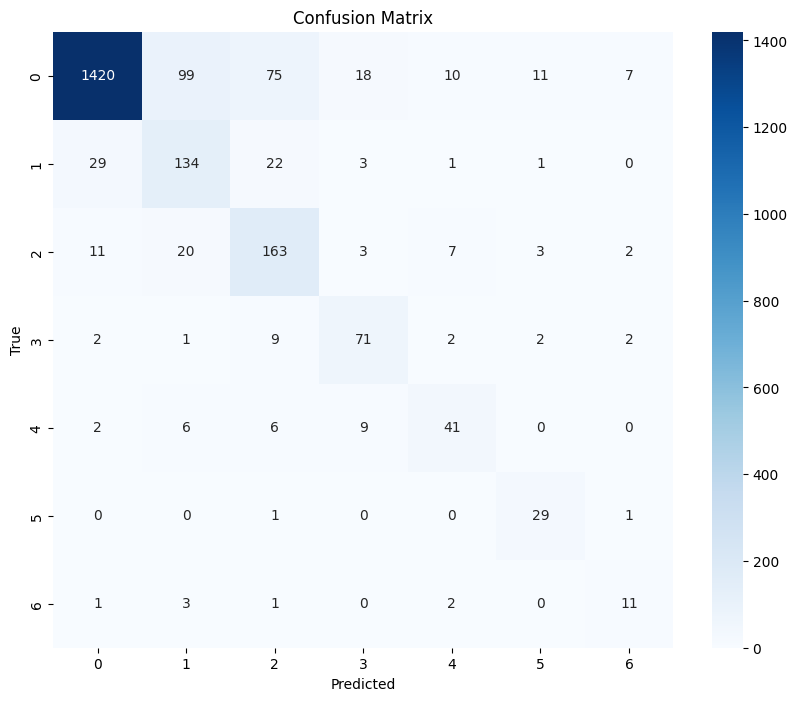

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.87      0.91      1640
           1       0.51      0.71      0.59       190
           2       0.59      0.78      0.67       209
           3       0.68      0.80      0.74        89
           4       0.65      0.64      0.65        64
           5       0.63      0.94      0.75        31
           6       0.48      0.61      0.54        18

    accuracy                           0.83      2241
   macro avg       0.64      0.76      0.69      2241
weighted avg       0.87      0.83      0.84      2241



In [24]:
evaluate(model1, testloader, device)

# Model 2: Finetuning the top few layers

## Model 2.1

In [25]:
# Load pretrained ResNet50 model
model2 = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
model2.fc = nn.Linear(in_features=2048, out_features=7)

In [26]:
# Freeze specific layers
freeze_layers = ['conv1', 'bn1', 'relu', 'maxpool', 'layer1', 'layer2', 'layer3']

# Iterate over named modules and freeze/unfreeze as required
for name, module in model2.named_children():
    if name in freeze_layers:
        for param in module.parameters():
            param.requires_grad = False
    else:
        for param in module.parameters():
            param.requires_grad = True

In [27]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
history2 = train(model2, trainloader, device, num_epochs=15, lr=0.01, momentum=0.8, step_size=5, gamma=0.5)

[Epoch  1/15 Iter   219/657]: train_loss = 1.3870
[Epoch  1/15 Iter   438/657]: train_loss = 0.8588
[Epoch  1/15 Iter   657/657]: train_loss = 0.7101
[Epoch  2/15 Iter   219/657]: train_loss = 0.5721
[Epoch  2/15 Iter   438/657]: train_loss = 0.5108
[Epoch  2/15 Iter   657/657]: train_loss = 0.4881
[Epoch  3/15 Iter   219/657]: train_loss = 0.3887
[Epoch  3/15 Iter   438/657]: train_loss = 0.3509
[Epoch  3/15 Iter   657/657]: train_loss = 0.3437
[Epoch  4/15 Iter   219/657]: train_loss = 0.2854
[Epoch  4/15 Iter   438/657]: train_loss = 0.2884
[Epoch  4/15 Iter   657/657]: train_loss = 0.2706
[Epoch  5/15 Iter   219/657]: train_loss = 0.2380
[Epoch  5/15 Iter   438/657]: train_loss = 0.2393
[Epoch  5/15 Iter   657/657]: train_loss = 0.2318
[Epoch  6/15 Iter   219/657]: train_loss = 0.1783
[Epoch  6/15 Iter   438/657]: train_loss = 0.1409
[Epoch  6/15 Iter   657/657]: train_loss = 0.1567
[Epoch  7/15 Iter   219/657]: train_loss = 0.1222
[Epoch  7/15 Iter   438/657]: train_loss = 0.1560


Accuracy: 0.84


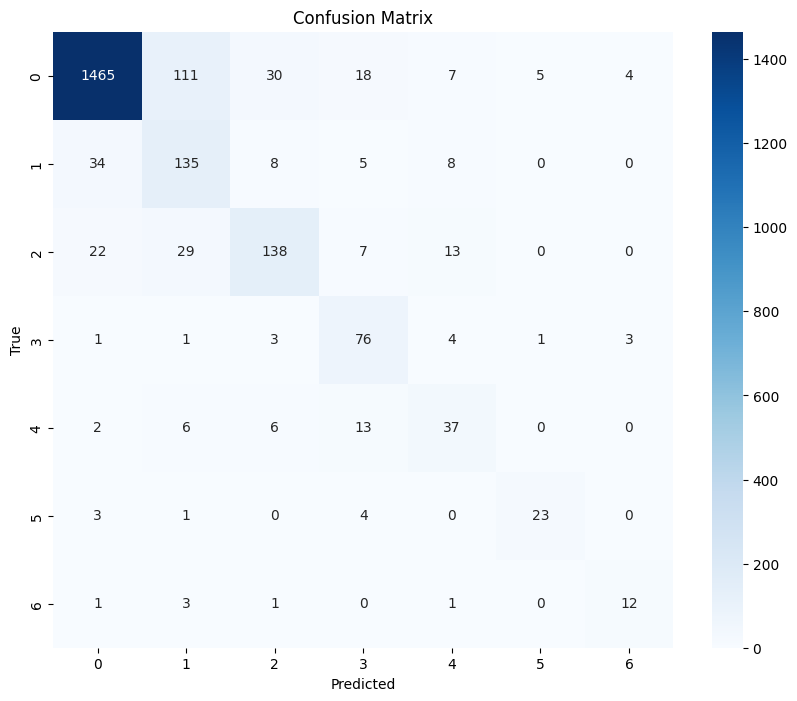

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.89      0.92      1640
           1       0.47      0.71      0.57       190
           2       0.74      0.66      0.70       209
           3       0.62      0.85      0.72        89
           4       0.53      0.58      0.55        64
           5       0.79      0.74      0.77        31
           6       0.63      0.67      0.65        18

    accuracy                           0.84      2241
   macro avg       0.68      0.73      0.70      2241
weighted avg       0.87      0.84      0.85      2241



In [28]:
evaluate(model2, testloader, device)

## Model 2.2 Hyperparameter Tuning

In [29]:
# Load pretrained ResNet50 model
model2t = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
model2t.fc = nn.Linear(in_features=2048, out_features=7)

In [30]:
# Freeze specific layers
freeze_layers = ['conv1', 'bn1', 'relu', 'maxpool', 'layer1', 'layer2', 'layer3']

# Iterate over named modules and freeze/unfreeze as required
for name, module in model2t.named_children():
    if name in freeze_layers:
        for param in module.parameters():
            param.requires_grad = False
    else:
        for param in module.parameters():
            param.requires_grad = True

In [31]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
history2t = train(model2t, trainloader, device, num_epochs=15, lr=0.1, momentum=0.6, step_size=5, gamma=0.5)

[Epoch  1/15 Iter   219/657]: train_loss = 1.1768
[Epoch  1/15 Iter   438/657]: train_loss = 0.7445
[Epoch  1/15 Iter   657/657]: train_loss = 0.5655
[Epoch  2/15 Iter   219/657]: train_loss = 0.4619
[Epoch  2/15 Iter   438/657]: train_loss = 0.4245
[Epoch  2/15 Iter   657/657]: train_loss = 0.3598
[Epoch  3/15 Iter   219/657]: train_loss = 0.3152
[Epoch  3/15 Iter   438/657]: train_loss = 0.2792
[Epoch  3/15 Iter   657/657]: train_loss = 0.2964
[Epoch  4/15 Iter   219/657]: train_loss = 0.2483
[Epoch  4/15 Iter   438/657]: train_loss = 0.1981
[Epoch  4/15 Iter   657/657]: train_loss = 0.2018
[Epoch  5/15 Iter   219/657]: train_loss = 0.1973
[Epoch  5/15 Iter   438/657]: train_loss = 0.1671
[Epoch  5/15 Iter   657/657]: train_loss = 0.1859
[Epoch  6/15 Iter   219/657]: train_loss = 0.1142
[Epoch  6/15 Iter   438/657]: train_loss = 0.0954
[Epoch  6/15 Iter   657/657]: train_loss = 0.1021
[Epoch  7/15 Iter   219/657]: train_loss = 0.0909
[Epoch  7/15 Iter   438/657]: train_loss = 0.0836


Accuracy: 0.85


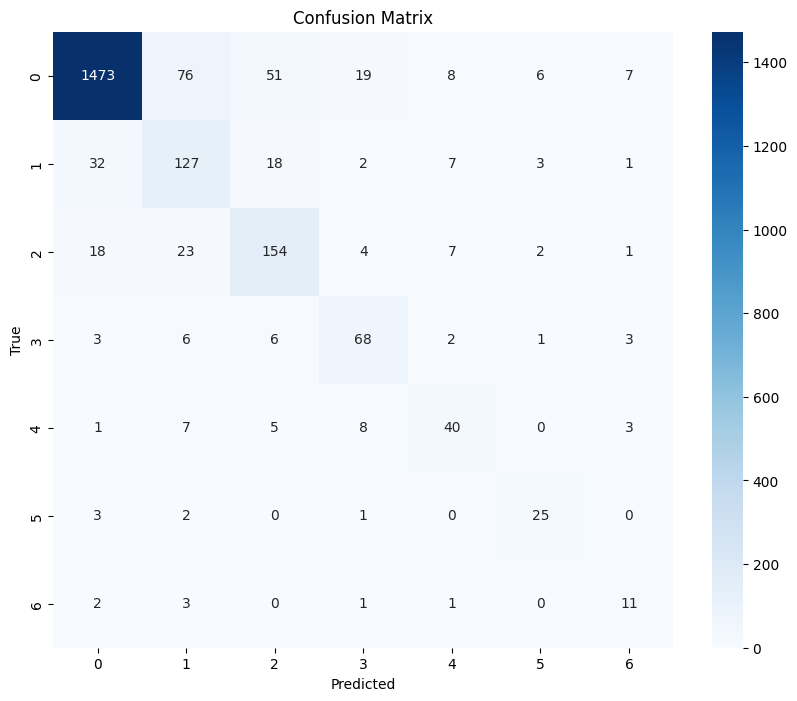

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.90      0.93      1640
           1       0.52      0.67      0.59       190
           2       0.66      0.74      0.70       209
           3       0.66      0.76      0.71        89
           4       0.62      0.62      0.62        64
           5       0.68      0.81      0.74        31
           6       0.42      0.61      0.50        18

    accuracy                           0.85      2241
   macro avg       0.64      0.73      0.68      2241
weighted avg       0.87      0.85      0.85      2241



In [32]:
evaluate(model2t, testloader, device)

# Model 3: As a fixed feature extractor

In [33]:
# Load pretrained ResNet50 model
model3 = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
model3.fc = nn.Linear(in_features=2048, out_features=7)

In [34]:
# Freeze specific layers
freeze_layers = ['conv1', 'bn1', 'relu', 'maxpool', 'layer1', 'layer2', 'layer3','layer4']

# Iterate over named modules and freeze/unfreeze as required
for name, module in model3.named_children():
    if name in freeze_layers:
        for param in module.parameters():
            param.requires_grad = False
    else:
        for param in module.parameters():
            param.requires_grad = True

In [35]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
history3 = train(model3, trainloader, device, num_epochs=15, lr=0.01, step_size=5, gamma=0.1)

[Epoch  1/15 Iter   219/657]: train_loss = 1.6086
[Epoch  1/15 Iter   438/657]: train_loss = 1.3553
[Epoch  1/15 Iter   657/657]: train_loss = 1.2239
[Epoch  2/15 Iter   219/657]: train_loss = 1.1528
[Epoch  2/15 Iter   438/657]: train_loss = 1.1149
[Epoch  2/15 Iter   657/657]: train_loss = 1.0417
[Epoch  3/15 Iter   219/657]: train_loss = 0.9832
[Epoch  3/15 Iter   438/657]: train_loss = 0.9594
[Epoch  3/15 Iter   657/657]: train_loss = 0.9585
[Epoch  4/15 Iter   219/657]: train_loss = 0.9443
[Epoch  4/15 Iter   438/657]: train_loss = 0.8912
[Epoch  4/15 Iter   657/657]: train_loss = 0.8943
[Epoch  5/15 Iter   219/657]: train_loss = 0.8836
[Epoch  5/15 Iter   438/657]: train_loss = 0.8726
[Epoch  5/15 Iter   657/657]: train_loss = 0.8569
[Epoch  6/15 Iter   219/657]: train_loss = 0.8339
[Epoch  6/15 Iter   438/657]: train_loss = 0.7702
[Epoch  6/15 Iter   657/657]: train_loss = 0.7914
[Epoch  7/15 Iter   219/657]: train_loss = 0.8174
[Epoch  7/15 Iter   438/657]: train_loss = 0.8044


Accuracy: 0.72


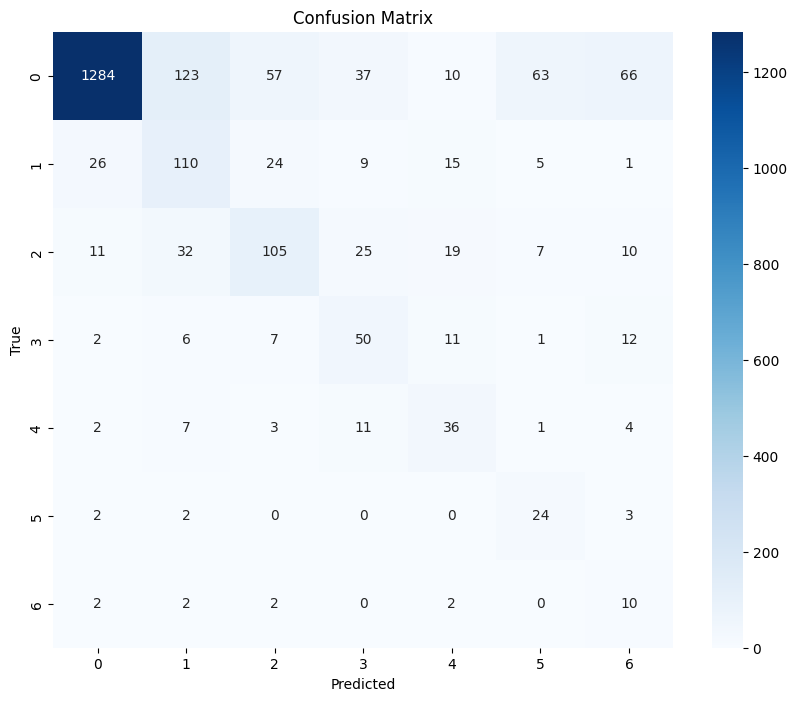

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.78      0.86      1640
           1       0.39      0.58      0.47       190
           2       0.53      0.50      0.52       209
           3       0.38      0.56      0.45        89
           4       0.39      0.56      0.46        64
           5       0.24      0.77      0.36        31
           6       0.09      0.56      0.16        18

    accuracy                           0.72      2241
   macro avg       0.43      0.62      0.47      2241
weighted avg       0.82      0.72      0.76      2241



In [36]:
evaluate(model3, testloader, device)

# Compare cost plots of all models

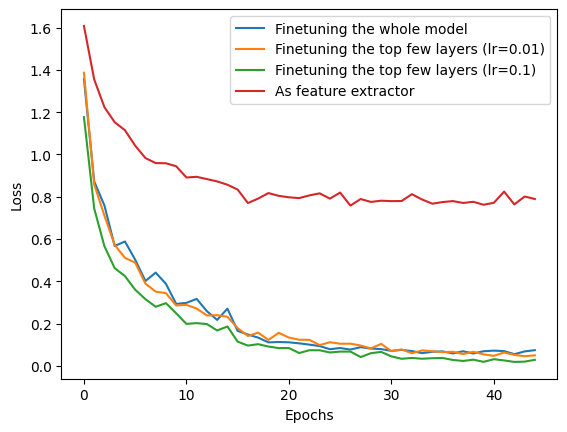

In [37]:
# Plotting the data
plt.plot(history1, label='Finetuning the whole model')
plt.plot(history2, label='Finetuning the top few layers (lr=0.01)')
plt.plot(history2t, label='Finetuning the top few layers (lr=0.1)')
plt.plot(history3, label='As feature extractor')

# Adding labels
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Adding a legend
plt.legend()

# Displaying the plot
plt.show()

## Save/Load History

In [ ]:
import shutil
import pickle

In [ ]:
"""
# Source directory
source_dir = "/kaggle/input/historys"

# Destination directory
destination_dir = "/kaggle/working/historys"

shutil.copytree(source_dir, destination_dir)
"""

In [ ]:
# Save history to a file
with open('training_history1.pkl', 'wb') as f:
    pickle.dump(history1, f)

In [ ]:
# Save history to a file
with open('training_history2.pkl', 'wb') as f:
    pickle.dump(history2, f)

In [ ]:
# Save history to a file
with open('training_history2t.pkl', 'wb') as f:
    pickle.dump(history2t, f)

In [ ]:
# Save history to a file
with open('training_history3.pkl', 'wb') as f:
    pickle.dump(history3, f)

In [ ]:
# Load history from file
with open("/kaggle/working/history/training_history2.pkl", 'rb') as f:
    history2 = pickle.load(f)

# Save/Load Model

In [38]:
# Define the file path where you want to save the model
save_path = "/kaggle/working/model1_resnet50.pth"
# Save the trained model
torch.save(model1.state_dict(), save_path)

In [39]:
# Define the file path where you want to save the model
save_path = "/kaggle/working/model2_resnet50.pth"
# Save the trained model
torch.save(model2.state_dict(), save_path)

In [40]:
# Define the file path where you want to save the model
save_path = "/kaggle/working/model2t_resnet50.pth"
# Save the trained model
torch.save(model2t.state_dict(), save_path)

In [41]:
# Define the file path where you want to save the model
save_path = "/kaggle/working/model3_resnet50.pth"
# Save the trained model
torch.save(model3.state_dict(), save_path)

In [ ]:
# Load the state dictionary into the model
model2.load_state_dict(torch.load(save_path))

In [44]:
ls /kaggle/working/

Dataset/             model2_resnet50.pth   model3_resnet50.pth
model1_resnet50.pth  model2t_resnet50.pth


In [ ]:
# Load the state dictionary into the model
save_path = "/kaggle/working/test.pth" # replace test.pth with the desire model filename
modeltest = models.resnet50()
modeltest.fc = nn.Linear(in_features=2048, out_features=7)
modeltest.load_state_dict(torch.load(save_path))
modeltest.to(device)
evaluate(modeltest, testloader, device)